In [1]:
import os
import json
import dgl
import random
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set_theme(style="darkgrid")
rcParams['figure.dpi'] = 300


In [2]:
# !!! make sure only run this cell once

os.chdir('../')

In [3]:
%load_ext autoreload
%autoreload 1

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [5]:
%aimport utils.result
%aimport utils.vis

from utils.result import load_model
from utils.vis import plot_spectrum, TestDataset, IntermediateRecorder

# Setup CUDA

In [6]:
device = torch.device("cuda")
torch.cuda.set_device(1)

device

device(type='cuda')

# Utilities

In [7]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device.type == 'cuda':
        torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [8]:
def run_model(model, recorder, G, x0, e0):
    with torch.no_grad():
        final_out = model(G, x0, e0, recorder)
        return final_out

# Load Models

In [12]:
model_paths = ['_out/molecules_graph_regression/z_gcn', '_out/molecules_graph_regression/z_sogcn_nogru', '_out/molecules_graph_regression/z_gcn_gru', '_out/molecules_graph_regression/z_sogcn']

model_ls = [load_model(pth, device) for pth in model_paths]

print('Models:')
model_ls

== Details:
Dataset = ZINC
Model Type = GCN , Model Name = z_gcn
Seed = 41
Net params = {'L': 16, 'hidden_dim': 172, 'out_dim': 172, 'residual': True, 'readout': 'mean', 'in_feat_dropout': 0.0, 'dropout': 0.0, 'batch_norm': True, 'self_loop': False, 'gpu_id': 3, 'batch_size': 128, 'max_order': 2, 'gru': False, 'activation': 'relu', 'edge_feat': False, 'num_atom_type': 28, 'num_bond_type': 4, 'total_param': 505079}
Ckpt path = _out/molecules_graph_regression/z_gcn/checkpoints/GCN_ZINC_GPU3_08h41m10s_on_Sep_12_2020/RUN_/epoch_175.pkl
Restoring ckpt...
Ckpt restored.

== Details:
Dataset = ZINC
Model Type = SoGCN , Model Name = z_sogcn_nogru
Seed = 41
Net params = {'L': 16, 'hidden_dim': 105, 'out_dim': 105, 'residual': True, 'readout': 'sum', 'in_feat_dropout': 0.0, 'dropout': 0.0, 'batch_norm': True, 'self_loop': False, 'max_order': 2, 'gru': False, 'gpu_id': 0, 'batch_size': 128, 'activation': 'relu', 'num_atom_type': 28, 'num_bond_type': 4, 'total_param': 544097}
Ckpt path = _out/mole

[{'model': GCNNet(
    (in_feat_dropout): Dropout(p=0.0, inplace=False)
    (embedding_h): Embedding(28, 172)
    (layers): ModuleList(
      (0): GCNLayer(in_channels=172, out_channels=172, residual=True, activation=ReLU())
      (1): GCNLayer(in_channels=172, out_channels=172, residual=True, activation=ReLU())
      (2): GCNLayer(in_channels=172, out_channels=172, residual=True, activation=ReLU())
      (3): GCNLayer(in_channels=172, out_channels=172, residual=True, activation=ReLU())
      (4): GCNLayer(in_channels=172, out_channels=172, residual=True, activation=ReLU())
      (5): GCNLayer(in_channels=172, out_channels=172, residual=True, activation=ReLU())
      (6): GCNLayer(in_channels=172, out_channels=172, residual=True, activation=ReLU())
      (7): GCNLayer(in_channels=172, out_channels=172, residual=True, activation=ReLU())
      (8): GCNLayer(in_channels=172, out_channels=172, residual=True, activation=ReLU())
      (9): GCNLayer(in_channels=172, out_channels=172, residual

# Prepare Data

In [13]:
'''
Load data
'''
dataset_name = model_ls[0]['dataset']
dataset = TestDataset(dataset_name, device)

[I] Loading dataset ZINC...
max in-degrees, out-degrees: 4 4
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 7.7388s


# Run Model

In [14]:
set_seed(1)

In [15]:
'''
Retrieve data and run model
'''

'''
Data for SoGCN+GRU > SoGCN > GCN+GRU > GCN:
[2, 13, 25, 28, 33, 37, 38, 41, 44, 66, 74, 75, 76, 96, 103, 108, 117, 121, 147, 156, 165, 167, 176, 206, 208, 211, 230, 231, 233, 234, 237, 246, 249, 253, 255, 265, 267, 273, 274, 299, 305, 325, 328, 333, 337, 340, 342, 353, 355, 372, 378, 387, 393, 395, 402, 407, 409, 412, 413, 416, 421, 429, 432, 462, 493, 500, 509, 516, 527, 563, 565, 570, 573, 580, 594, 597, 602, 612, 614, 625, 642, 648, 652, 658, 662, 665, 668, 676, 686, 687, 691, 697, 705, 708, 713, 726, 741, 743, 756, 757, 772, 777, 790, 809, 828, 829, 835, 845, 876, 878, 879, 897, 900, 901, 905, 911, 924, 925, 926, 940, 955, 959, 960, 970, 990, 993, 997]

Used in paper: 993, 206, 117, 147
'''

G, label, X0, E0, U = dataset.pick(993)

recorder_ls = []

for item in model_ls:
    model = item['model']
    model_name = item['model_name']
    ckpt_path = item['path']
    
    print('%s (%s)' % (model_name, ckpt_path))
    recorder = IntermediateRecorder(model_name)
    f_out = run_model(model, recorder, G, X0, E0)
    
    recorder_ls.append(recorder)

z_gcn (_out/molecules_graph_regression/z_gcn/checkpoints/GCN_ZINC_GPU3_08h41m10s_on_Sep_12_2020/RUN_/epoch_175.pkl)
z_sogcn_nogru (_out/molecules_graph_regression/z_sogcn_nogru/checkpoints/SoGCN_ZINC_GPU0_02h07m27s_on_Feb_07_2021/RUN_/epoch_192.pkl)
z_gcn_gru (_out/molecules_graph_regression/z_gcn_gru/checkpoints/GCN_ZINC_GPU2_13h02m10s_on_Sep_13_2020/RUN_/epoch_215.pkl)
z_sogcn (_out/molecules_graph_regression/z_sogcn/checkpoints/SoGCN_ZINC_GPU2_19h43m35s_on_Feb_06_2021/RUN_/epoch_197.pkl)


# Visualization

vis layers: [16]


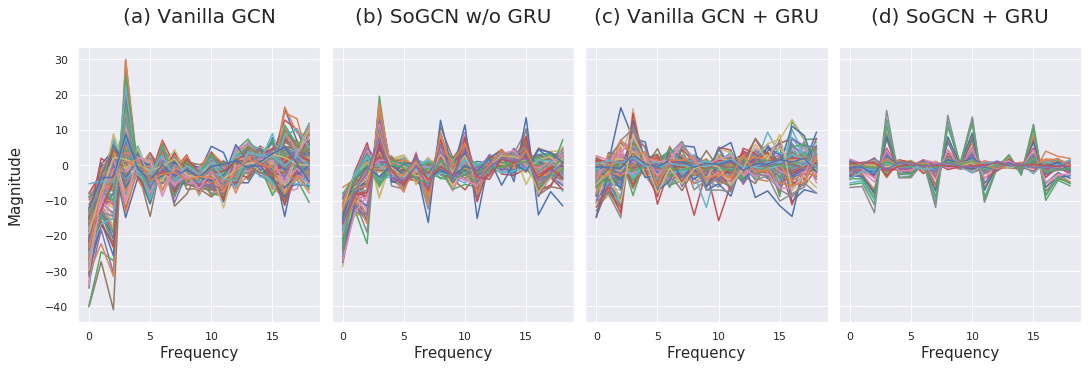

In [16]:
'''
Freq - magnitude plot
'''


title_ls = ['(a) Vanilla GCN', '(b) SoGCN w/o GRU', '(c) Vanilla GCN + GRU', '(d) SoGCN + GRU']

vis_out_ls = [[rec['input'][0]] + rec['out'] for rec in recorder_ls]
model_name_ls = [rec.target_name for rec in recorder_ls]

vis_layers = [16]
print('vis layers:', vis_layers)

subplots_w = len(vis_out_ls)
subplots_h = len(vis_layers)

plot_w = 15
h_w_ratio = 10 / 7.5

fig, ax = plt.subplots(subplots_h, subplots_w, sharex=True, sharey=True, figsize=(plot_w, subplots_h * h_w_ratio * (plot_w / subplots_w)), constrained_layout=True)
if len(vis_layers) <= 1:
    ax = ax[np.newaxis, ...]
    
for i in range(subplots_w):
    for j in range(subplots_h):
        L = vis_layers[j]
        plot_spectrum((vis_out_ls[i][L], U), ax[j, i], None, 'curves', y_label=None)

for i in range(subplots_w):
    ax[0, i].annotate(title_ls[i],
                xy=(0.5, 1), xytext=(0, 25), xycoords='axes fraction', textcoords='offset points',
                size=20, ha='center', va='baseline')

for j in range(subplots_h):
    ax[j, 0].annotate('Magnitude',
            xy=(0, 0.5), xytext=(-ax[j,0].yaxis.labelpad - 15, 0),
            xycoords=ax[j,0].yaxis.label, textcoords='offset points',
            size=15, ha='right', va='center', rotation=90)

if subplots_h > 1:
    for j in range(subplots_h):
        ax[j, 0].annotate(('L=%s' % vis_layers[j]) if vis_layers[j] != 0 else 'Input',
                    xy=(0, 0.5), xytext=(-ax[j, 0].yaxis.labelpad - 45, 0),
                    xycoords=ax[j, 0].yaxis.label, textcoords='offset points',
                    size=20, ha='right', va='center')


if not os.path.exists('vis_out'):
    os.makedirs('vis_out')
fig.savefig('vis_out/vis_molecules_spectrum.pdf')